Area = 20958.5


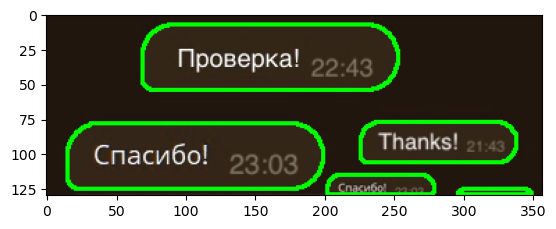

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# загрузка изображения и применение цветового фильтра в заданном цветовом диапазоне
image = cv2.imread(os.path.join('images', 'messages_example.jpeg'))
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([0, 0, 40], dtype="uint8")
upper = np.array([255, 255, 255], dtype="uint8")
mask = cv2.inRange(image, lower, upper)
detected = cv2.bitwise_and(original, original, mask=mask)

# удаление шумов
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# поиск контуров и суммарной площади занимаемой сообщениями области
contours = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
area = 0
for c in contours:
    area += cv2.contourArea(c)
    cv2.drawContours(original,[c], 0, (0,255,0), 2)

print('Area =', area)
plt.imshow(original)
plt.show()

In [2]:
# uncomment next line to install easyocr
#!pip3 install easyocr

In [3]:
import easyocr

In [4]:
reader = easyocr.Reader(['en','ru'])
result = reader.readtext(original)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[90, 20], [240, 20], [240, 50], [90, 50]],
  'Проверка! 22.43',
  0.9458684691611365),
 ([[30, 88], [122, 88], [122, 112], [30, 112]],
  'Спасибо!',
  0.9999220270710725),
 ([[236, 80], [334, 80], [334, 104], [236, 104]],
  'Thanks! 21.43',
  0.9690900561209379),
 ([[128, 96], [186, 96], [186, 120], [128, 120]], '23.03', 0.9999513259904851),
 ([[210, 122], [246, 122], [246, 128], [210, 128]],
  '[писыыт',
  0.0832517878185415)]

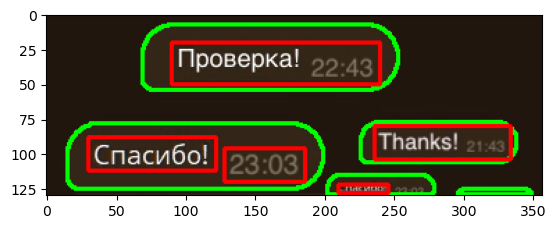

In [5]:
for res in result:
    original = cv2.rectangle(original, res[0][0], res[0][2], (255,0,0), 2)
plt.imshow(original)
plt.show()

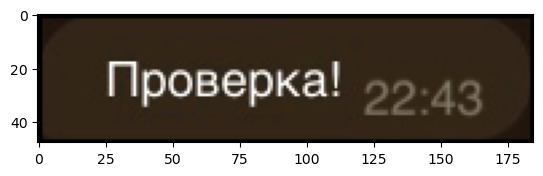

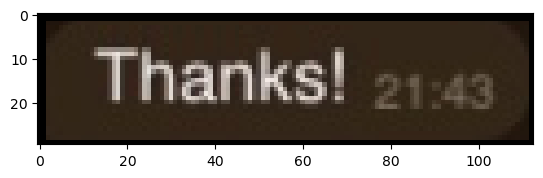

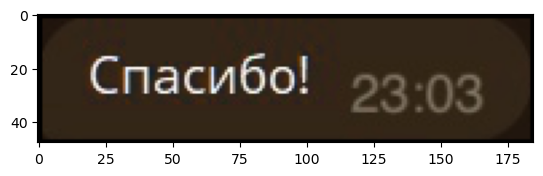

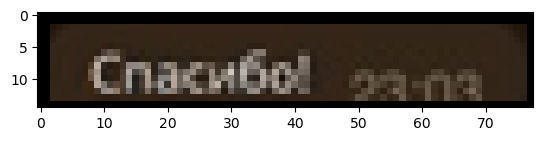

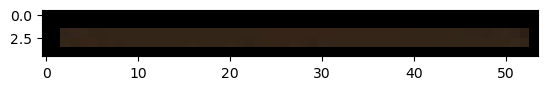

In [6]:
messages_list = []

for contour in reversed(contours):

    # выделение и прорисовка прямоугольников с сообщениями
    x, y, w, h = cv2.boundingRect(contour)
    rect = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
     
    # вырезаем прямоугольники с сообщениями для дальнейшей OCR обработки
    cropped = image[y:y + h, x:x + w]

    cropped = cv2.cvtColor(cropped, cv2.COLOR_HSV2BGR)
    messages_list.append(cropped)
    plt.imshow(cropped, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [7]:
import time

start_time = time.time()

all_results = []
for message in messages_list:
    all_results += reader.readtext(message, detail=0)

print('Elapsed time 1:', time.time()-start_time, 's')

all_results

Elapsed time 1: 0.2803308963775635 s


['Проверка! 22.43', 'Thanks! 21 43', 'Спасибо!', '23.03', 'Епаскuн']

In [8]:
# requires Tesseract OCR local installation

import pytesseract

start_time = time.time()

tesseract_results = []
for message in messages_list:
    tesseract_results += [pytesseract.image_to_string(message,lang='eng+rus')]

print('Elapsed time 2:', time.time()-start_time, 's')

tesseract_results

Elapsed time 2: 0.7748408317565918 s


['Проверка!\n', 'Thanks!\n', 'Спасибо! 23.03\n', 'Спасибо сала.\n', '']

Pytesseract отрабатывает медленнее (примерно в 3 раза), чем EasyOCR.

При этом EasyOCR должен работать ещё в разы быстрее при запуске на GPU.